In [6]:
import matplotlib.pyplot as plt
import cvxpy as cp
import numpy as np
np.random.seed(2)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica Neue"],
    "font.size": 28,
})

In [7]:
# Utility functions
def polish(x, tol=1e-03):
    idx = np.isclose(x, np.round(x), rtol=1e-03, atol=1e-04)
    x = np.copy(x)
    x[idx] = np.round(x[idx])
    return x


def is_feasible(x, tol=1e-3):
    """Determines if x is in the feasible set Ax <= b (with tolerance)."""
    if np.any(A @ x - b > tol):
        return False
    return True

                
def argmin_leaves(nodes, Uglob):
    """Returns the node with lowest lower bound, from a list of nodes.
    """
    m = min([x.lower for x in nodes])
    for x in nodes:
        if x.lower == m:
            return x
        
def incumbent(Uglob, incumbent, left, right):
    if Uglob == left.upper:
        return left.incumbent
    elif Uglob == right.upper:
        return right.incumbent
    else:
        return incumbent

In [8]:
# Define node object
class node:
    """Create node of a branch-and-bound tree with size n. Specify the
    optional parent if the node is not at the top of the tree.
    """

    def __init__(self, n, cuts=[], parent=None):
        self.cuts = cuts
        self.parent = parent
        self.left = None
        self.right = None
        self.n = n
        self.alive = True
        self.incumbent = None
        self.x_relaxed = None
        self.lower = np.inf
        self.upper = np.inf
        
    def depth(self):
        d = 0
        p = self.parent
        while p is not None:
            d += 1
            p = p.parent      
        return d
                
    def solve(self):
        """Find upper and lower bounds of the sub-problem belonging to
        this node."""
        x = cp.Variable(self.n)

        constraints = [A @ x <= b]
        for i, d, f in self.cuts:
            constraints += [d * x[i] <= f]

        problem = cp.Problem(cp.Minimize(c @ x), constraints)
        problem.solve(solver=cp.SCIPY)

        if x.value is None:
            # We couldn't find a solution.
            self.raw = None
            self.lower = np.inf
            self.upper = np.inf
            return np.inf

        # Use heuristic to choose which variable we should split on next. Don't
        # choose a variable we have already set.
        x_polish = polish(x.value)
        self.x_relaxed = x_polish
        x_round = np.round(x_polish)
        self.picknext = np.argmax(abs(x_polish - x_round))
        self.lower = problem.objective.value

        if is_feasible(x_round):
            self.upper = c @ x_round
            self.incumbent = x_round
        else:
            self.upper = np.inf
            
        return self.upper

    def addleft(self):
        """Add a node to the left-hand side of the tree and solve."""
        if self.left is None:
            # add cut by rounding relaxation solution
            new_cut = [(self.picknext, 1, np.floor(self.x_relaxed[self.picknext]))]
            self.left = node(self.n, self.cuts + new_cut, self)

        self.left.solve()
        return self.left
    
    def addright(self):
        """Add a node to the right-hand side of the tree and solve."""
        if self.right is None:
            # add cut by rounding relaxation solution
            new_cut = [(self.picknext, -1, -np.ceil(self.x_relaxed[self.picknext]))]
            self.right = node(self.n, self.cuts + new_cut, self)

        self.right.solve()
        return self.right
    
    def nodes(self, all=False):
        """Returns a list of all nodes that live at, or below, this point.

        If all is False, return nodes only if they are stil alive.
        """

        coll = []
        if self.alive or all:
            coll += [self]
        if self.left is not None and (self.left.alive or all):
            coll += self.left.nodes(all)
        if self.right is not None and (self.right.alive or all):
            coll += self.right.nodes(all)

        return coll

    def __repr__(self, level=0):
        """Utility to display bnb tree"""
        ret = "\t"*level+repr(self.depth())
        ret += ' <node: cuts=%d, L=%.2f, U=%.2f>' % (len(self.cuts), self.lower, self.upper)
        if any(self.cuts):
            ret += "\n"
            for i, d, f in self.cuts:
                ret += "\t"*level+"    %.2f x_%d <= %.2f\n" % (d, i, f)
        else:
            ret += "\n"
        
        if self.incumbent is not None:
            ret += "\t"*level+"  incumbent = " + str(self.incumbent) + "\n"
            
        if self.x_relaxed is not None:
            ret += "\t"*level+"  x_rel = " + str(self.x_relaxed) + "\n"
        
        if self.left is not None:
            ret += self.left.__repr__(level+1)
        if self.right is not None:
            ret += self.right.__repr__(level+1)
        return ret
   

In [9]:
def solve_bb(c, A, b):
    # Initialize history
    uppers = []
    lowers = []
    leavenums = []
    incumbents = []

    # Create the top node in the tree.
    top = node(n)

    Uglob = top.solve()
    incumbents.append(top.incumbent)
    Lglob = -np.inf
    leaves = [top]
    iter = 0
    max_iter = 20000
    tol = 1e-03

    # Expand the tree until the gap has disappeared.
    print("Branch and bound iterations")
    while Uglob - Lglob > tol:
        iter += 1
        # Expand the leaf with lowest lower bound.
        l = argmin_leaves(leaves, Uglob)
        left = l.addleft()
        right = l.addright()
        leaves.remove(l)
        leaves += [left, right]

        Lglob = min([x.lower for x in leaves])
        Uglob = min(Uglob, left.upper, right.upper)
        x_bb = incumbent(Uglob, incumbents[-1], left, right)

        # Prune anything except the currently optimal solution. Doesn't
        # actually affect the progress of the algorithm.
        for x in top.nodes():
            if x.lower > Uglob and x.upper != Uglob:
                x.alive = False
        
        if iter % 20 == 0:
            print("iter %3d.  L: %.5f, U: %.0f" %
                  (iter, Lglob, Uglob))

        # History
        lowers.append(Lglob)
        uppers.append(Uglob)
        leavenums.append(len([1 for x in leaves if x.alive]))
        incumbents.append(x_bb)

        if iter >= max_iter:
            break

    print("done.")
    
    return x_bb, top, iter, lowers, uppers, leavenums

In [10]:
# Solve small integer optimization from lecture
m, n = 20, 10
A = np.random.randn(m, n)
x0 = np.random.randn(n)
b = A.dot(x0) + 10 * np.random.rand(m)
c = np.random.randn(n)

# Solve with BB
x_bb, tree, iter, lowers, uppers, leavenums = solve_bb(c, A, b)

# Solve with SCIPY
x = cp.Variable(n, integer=True)
problem = cp.Problem(cp.Minimize(c @ x), [A @ x <= b])
problem.solve(solver=cp.SCIPY)
x_glpk = x.value

print("bnb solution x = ", x_bb)
print("glpk solution x = ", x_glpk)

Branch and bound iterations
iter  20.  L: -26.55738, U: inf
iter  40.  L: -25.96841, U: inf
iter  60.  L: -25.58092, U: inf
iter  80.  L: -25.35274, U: -24
iter 100.  L: -24.99127, U: -24
iter 120.  L: -24.79711, U: -24
iter 140.  L: -24.65188, U: -24
iter 160.  L: -24.48386, U: -24
done.
bnb solution x =  [-4. -7. -4. -3.  1. -7. -2.  9. -2. -1.]
glpk solution x =  [-3. -7. -5. -4. -2. -4.  1.  9. -3. -1.]


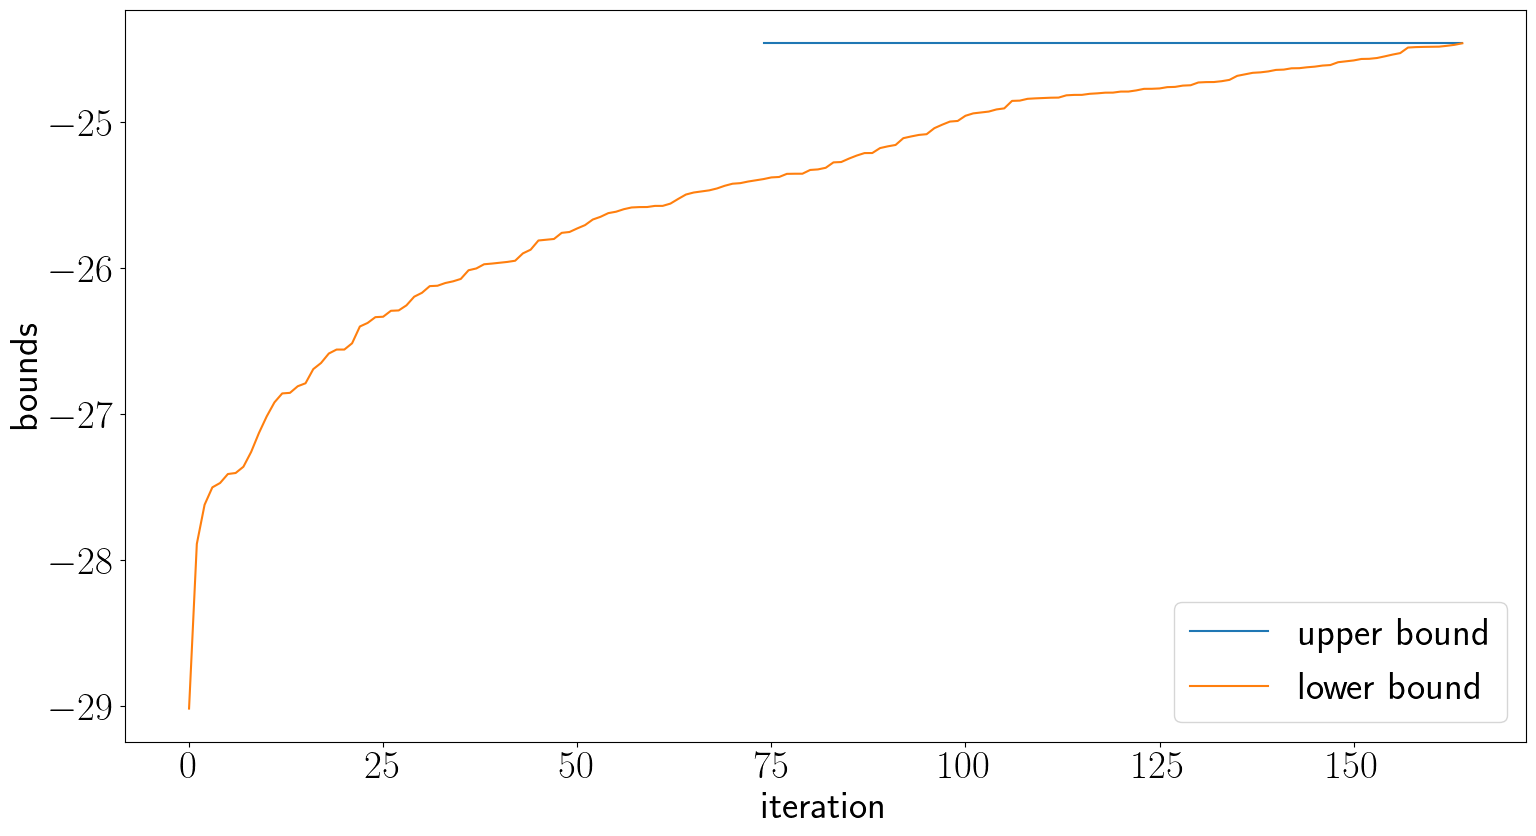

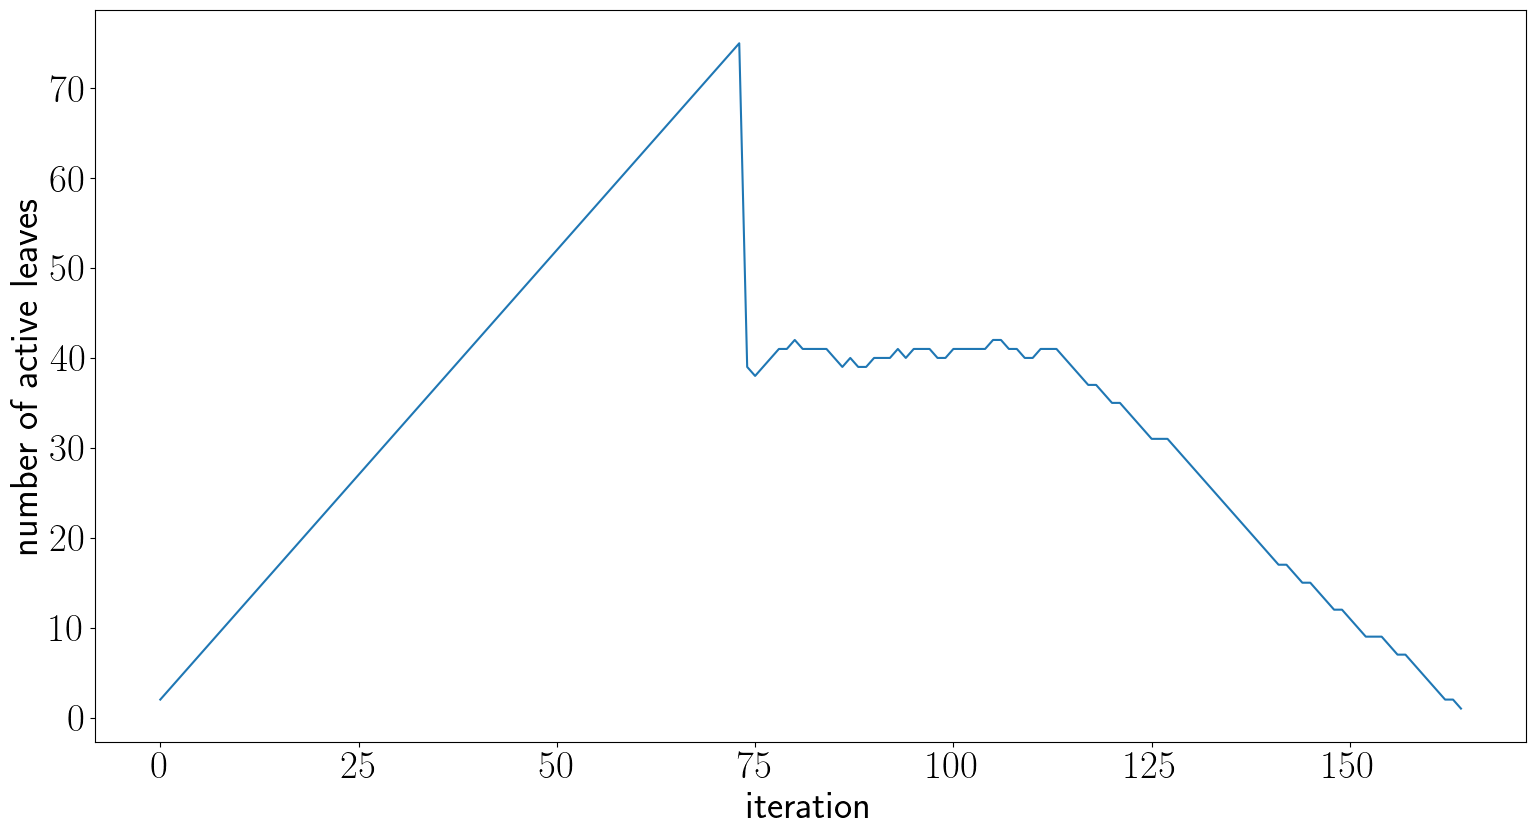

In [11]:
# Plot upper/lower bounds
# Not very meaningful for such a small example.
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(uppers)
ax.plot(lowers)
ax.legend(('upper bound', 'lower bound'), loc='lower right')
ax.set_xlabel('iteration')
ax.set_ylabel('bounds')
plt.tight_layout()
plt.savefig("bnb_bounds.pdf")

fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(range(iter), leavenums)
ax.set_xlabel('iteration')
ax.set_ylabel('number of active leaves')
plt.tight_layout()
plt.savefig("bnb_tree_leaves.pdf")